Küpper-Tetzel et al (2014) show that the optimal spacing schedule (contracting vs equal vs expanding), depends on the retention interval. 

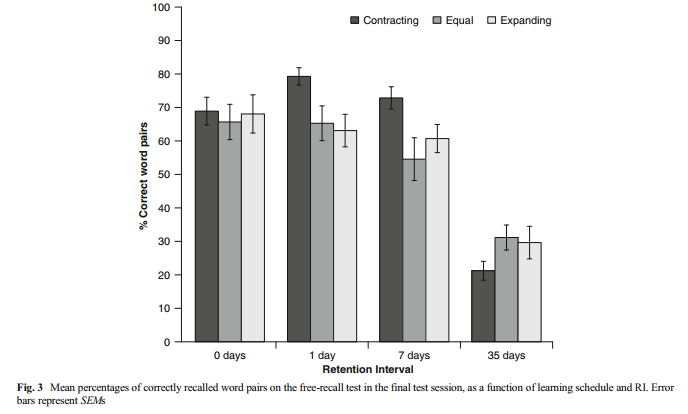

They use the procedure shown below with the following times:
* Contracting: ISI1 = 5 days, ISI2 = 1 day
* Equal: ISI1 = 3 days, ISI2 = 3 days
* Expanding: ISI1 = 1 day, ISI2 = 5 days

Retention interavl is: 15 min, 1 day, 7 days, 35 days

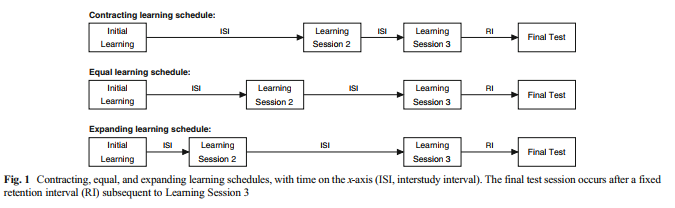

In [2]:
library(tidyverse)
library(colorRamps)
options(repr.plot.width=6, repr.plot.height=4)

base <- function(t, currentTime, p=0.65, d=0.2) {
  # the first increment is just p
  B=0
  deltaB = p
  # for every increment after that, check if it has occured yet (t[i] <= currentTime)
  # if it has occured, calculate B at time t[i], which is multiplying each increment 
  # by the forgetting function of how much time has passed since then
  # finally, calculate the current increment size based on B
  for (i in 2:length(t)) {
    if (t[i] <= currentTime) {
      B = sum(deltaB * (1 + t[i] - t[1:(i-1)])^(-d))
      deltaB[i] = p * (1-B)
    }
  }
  # set the time to 0 if the event hasn't occured yet (-1, because of the 1+time in the eq below
  # then calculate B at the current time)
  time = ifelse(currentTime - t[1:length(deltaB)] < 0, -1, currentTime - t[1:length(deltaB)])
  B = sum(deltaB * (1 + time)^(-d))
  return(B)
}

# generate data
data <- data.frame(gap12 = rep(c(5,3,1), each=4),
                   gap23 = rep(c(1,3,5), each=4),
                   delay = rep(c(0.01,1,7,35), 3))

# convert to seconds
data <- data  * 86400

data$b <- apply(data, 1, function(x) base(c(0, 
                                            x[1], 
                                            x[1]+x[2]), 
                                          x[1]+x[2]+x[3], p=0.65, d=0.2))
data$schedule <- c(rep(c('contracting','equal','expanding'), each=4))


In [3]:
data  %>% 
 arrange(delay, b)

gap12,gap23,delay,b,schedule
86400,432000,864,0.24460848,expanding
259200,259200,864,0.24923313,equal
432000,86400,864,0.25982391,contracting
86400,432000,86400,0.14976112,expanding
259200,259200,86400,0.15374387,equal
432000,86400,86400,0.16032545,contracting
86400,432000,604800,0.11923957,expanding
259200,259200,604800,0.12095502,equal
432000,86400,604800,0.12242678,contracting
86400,432000,3024000,0.09155224,expanding


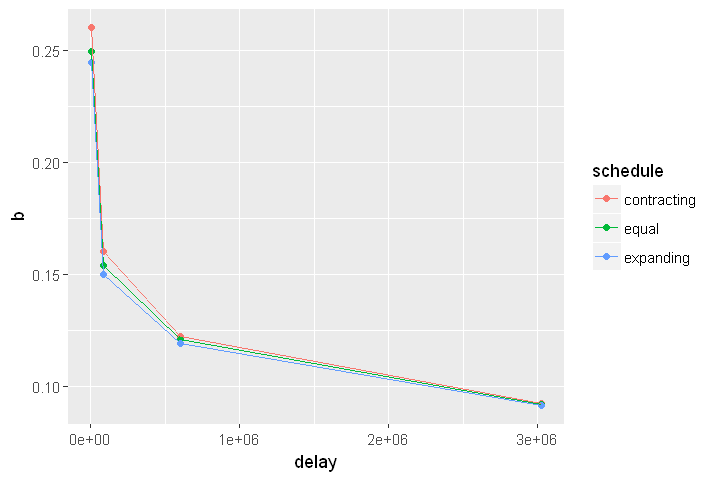

In [4]:
data  %>% 
    ggplot(aes(delay, b, color=schedule)) +
    geom_point() +
    geom_line()

The problem with this is that pairs were not presented once per session, but rather with a 2 dropout procedure until criterion. Since cued recall in session 2 is lower for contracting than equal or expanding, just because of the session interval, pairs in the contracting condition there will be presented more often until criterion. So let's model that.

In [48]:
gen_data <- function(par, gaps_list, gaps_names, delay, p, d) {
  get_t <- function(gaps) {
    reach_crit <- function(t) {
      b = 0.65
      while (b < crit) {
        t = c(t, max(t)+rep_delay)    
        b = base(t, max(t)+rep_delay)
      }
      return(t)
    }
    
    # SESSION1
    t = c(0)
    t = reach_crit(t)
    
    # LOOP OVER OTHER SESSIONs
    for (gap in gaps) {
      t = c(t, max(t) + gap)
      t = reach_crit(t)
    }
    
    return(t)
  }
  
  # assign parameters
  crit = par[1]
  rep_delay = par[2]
  p = par[3]
  d = par[4]
  
  # get data for each sequence in gaps_list
  data = data.frame(delay = delay)
  ts = list()
  for (i in 1:length(gaps_list)) {
    name = gaps_names[i]
    gaps = gaps_list[[i]]
    t = get_t(gaps)
    data[, name] = apply(data, 1, function(x) base(t, max(t) + x[1], p, d))
  }
  
  return(data)
}

Simulated data:

delay,contracting,equal,expanding
864,0.9041858,0.9035270,0.9033140
86400,0.6093494,0.5948256,0.5856711
604800,0.4512149,0.4529490,0.4476199
3024000,0.3179163,0.3227427,0.3201935


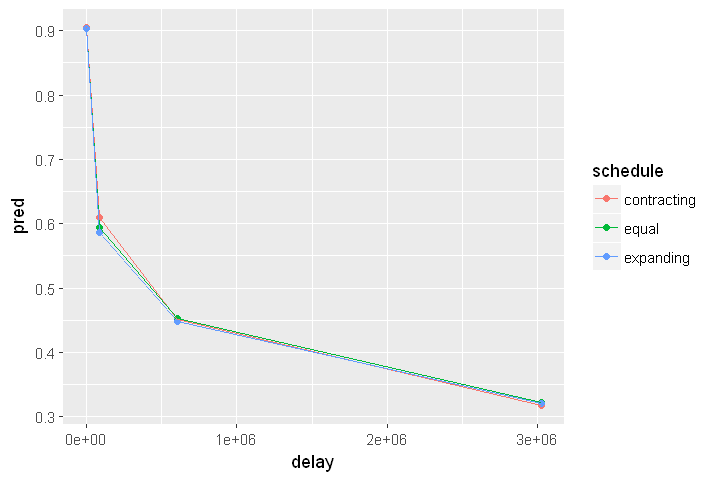

In [62]:
data = gen_data(c(0.99, 30, 0.99, 0.26), 
                list(c(5,1) * 86400, c(3,3) * 86400, c(2,4) * 86400), 
                c('contracting','equal','expanding'), 
                delay = c(0.01, 1, 7, 35) * 86400) 
data

data  %>% 
    gather(schedule, pred, -delay)  %>% 
    ggplot(aes(delay, pred, color=schedule)) +
    geom_point() +
    geom_line()

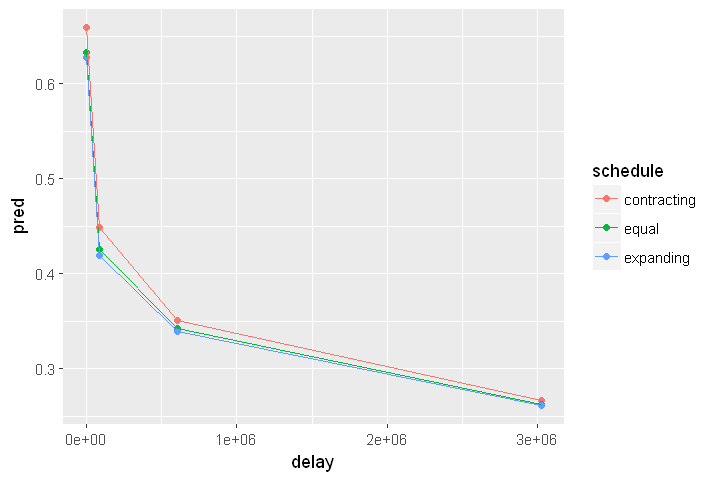

In [47]:
data  %>% 
    gather(schedule, pred, -delay)  %>% 
    ggplot(aes(delay, pred, color=schedule)) +
    geom_point() +
    geom_line()

Let's fit the function to the data.

In [1]:
errorFunc <- function(par, gaps_list, gaps_names, delay) {
    data <- gen_data(par, gaps_list, gaps_names, delay) 
    e = c(#abs(data[1,]$equal - data[2,]$contracting),
          #abs(data[1,]$expanding - data[2,]$contracting),
          #abs(data[1,]$expanding - data[2,]$equal),
          #data[2,]$equal - data[2,]$contracting,
          #data[2,]$expanding - data[2,]$contracting,
          #abs(data[2,]$expanding - data[2,]$equal),
          #data[3,]$equal - data[2,]$contracting,
          #data[3,]$expanding - data[2,]$contracting,
          #abs(data[3,]$expanding - data[2,]$equal),
          -(data[4,]$equal - data[2,]$contracting),
          -(data[4,]$expanding - data[2,]$contracting),
          abs(data[4,]$expanding - data[2,]$equal))
         
    error = sum(e)
    IRdisplay::display_text(paste0('Par: ', par[1], ' ', par[2], '; Error: ', error))
    return(error)
}

In [20]:
errorFunc(
            par = c(0.999,0.01),
            gaps_list = list(c(5,1), c(3,3), c(1,5)), 
            gaps_names = c('contracting','equal','expanding'), 
            delay = c(0.01, 1, 7, 35))

[1] "Par: 0.999 0.01; Error: 0.812970665436096"


[1] 0.8129707

In [ ]:
opt = optim(errorFunc,
            par = c(0.99,0.01),
            gaps_list = list(c(5,1), c(3,3), c(1,5)), 
            gaps_names = c('contracting','equal','expanding'), 
            delay = c(0.01, 1, 7, 35),
           control=list(trace=TRUE,REPORT=1))